# 🏙️ Dublin Rent Tracker – Exploratory Data Analysis (EDA)

This notebook performs Exploratory Data Analysis (EDA) on rental property listings in Dublin, scraped from Daft.ie using the `daftlistings` API.

Our goal is to understand pricing patterns, neighborhood trends, and housing characteristics such as number of bedrooms, bathrooms, and BER energy ratings. We'll also prepare this cleaned dataset for Power BI visualization and modeling in the next steps.

Key tasks covered:
- Cleaning and handling missing data
- Binning price ranges for grouped analysis
- Analyzing how rent varies with features like `bedrooms`, `bathrooms`, `ber`, and `district`
- Creating district-level classification (North vs South Dublin)
- Saving the final EDA dataset for Power BI


In [24]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook settings
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Loading dataset
df = pd.read_csv("../01_data/cleaned/daft_listings_cleaned.csv")
df.head()


,id,address,bedrooms,bathrooms,monthly_price,ber,category,daft_link,agent_name,has_video,has_virtual_tour,total_images,dublin_subcode
0,3916914,"Quayside Quarter, Dublin Landings, North Wall ...",1.0,1.0,2615,A3,Rent,http://www.daft.ie/for-rent/apartment-1-bedroo...,Cian Hynes,False,True,12,1.0
1,3916952,"Quayside Quarter, Dublin Landings, North Wall ...",2.0,2.0,3355,A3,Rent,http://www.daft.ie/for-rent/apartment-2-bedroo...,Cian Hynes,False,True,17,1.0
2,3917034,"Quayside Quarter, Dublin Landings, North Wall ...",3.0,3.0,4805,A3,Rent,http://www.daft.ie/for-rent/apartment-e2-602-3...,Cian Hynes,False,False,18,1.0
3,5705486,"Niche Living, Serviced Studio Apartments, Arde...",1.0,NaN,1990,A3,Rent,http://www.daft.ie/for-rent/studio-apartment-s...,Niche Living enquiries Rathmines,False,False,22,6.0
4,5987932,"O'Neill Court , Main Street, Belmayne, Dublin 13",1.0,1.0,1950,A1,Rent,http://www.daft.ie/for-rent/apartment-1-bed-on...,O'Neill Court,False,True,8,13.0


In [25]:

print(f"Shape: {df.shape}")
df.info()
df.isnull().sum().sort_values(ascending=False)


Shape: (1016, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1016 non-null   int64  
 1   address           1016 non-null   object 
 2   bedrooms          1014 non-null   float64
 3   bathrooms         898 non-null    float64
 4   monthly_price     1016 non-null   object 
 5   ber               920 non-null    object 
 6   category          1016 non-null   object 
 7   daft_link         1016 non-null   object 
 8   agent_name        1016 non-null   object 
 9   has_video         1016 non-null   bool   
 10  has_virtual_tour  1016 non-null   bool   
 11  total_images      1016 non-null   int64  
 12  dublin_subcode    817 non-null    float64
dtypes: bool(2), float64(3), int64(2), object(6)
memory usage: 89.4+ KB


dublin_subcode      199
bathrooms           118
ber                  96
bedrooms              2
id                    0
monthly_price         0
address               0
daft_link             0
category              0
agent_name            0
has_video             0
has_virtual_tour      0
total_images          0
dtype: int64

## Binning Monthly Rent into Ranges

Raw rent values span a wide and inconsistent range (e.g., from €800 to over €5000), making visual analysis messy. 

To address this, we bin the `monthly_price` into intervals of €300 to enable grouped analysis and better plotting. This `price_bin` column will help us study distribution trends across other variables.


In [26]:
# Converting 'monthly_price' to numeric, invalid parsing will become NaN
df['monthly_price'] = pd.to_numeric(df['monthly_price'], errors='coerce')

# Viewing rows that were invalid
invalid_prices = df[df['monthly_price'].isna()]
print(f"Invalid price entries: {len(invalid_prices)}")
invalid_prices[['monthly_price', 'address']].head()


Invalid price entries: 1


,monthly_price,address
20,NaN,"Rockpoint, Newtown Avenue, Blackrock, Co. Dublin"


In [27]:
# Dropping listings with no numeric price
df = df.dropna(subset=['monthly_price'])


In [28]:
# Defining bins and labels
bin_edges = list(range(500, 6000, 300))
labels = [f"{low}-{low+300}" for low in bin_edges[:-1]]
# Binning monthly_price into labeled ranges
df['price_bin'] = pd.cut(df['monthly_price'], bins=bin_edges, labels=labels, include_lowest=True)
# Checking distribution
df['price_bin'].value_counts().sort_index()


price_bin
500-800        4
800-1100      15
1100-1400     51
1400-1700     82
1700-2000    150
2000-2300    147
2300-2600    167
2600-2900     86
2900-3200     81
3200-3500     66
3500-3800     39
3800-4100     29
4100-4400     15
4400-4700     20
4700-5000     16
5000-5300      2
5300-5600      9
5600-5900      2
Name: count, dtype: int64

## Bivariate Analysis: Price Range vs Property Features

Now that we’ve binned the rent values, we explore how price categories relate to:
- Number of bedrooms
- Number of bathrooms
- BER energy ratings
- Dublin postal subcodes
- District (North vs South)

This helps us identify typical rent bands for each category and see how housing characteristics influence rental pricing.


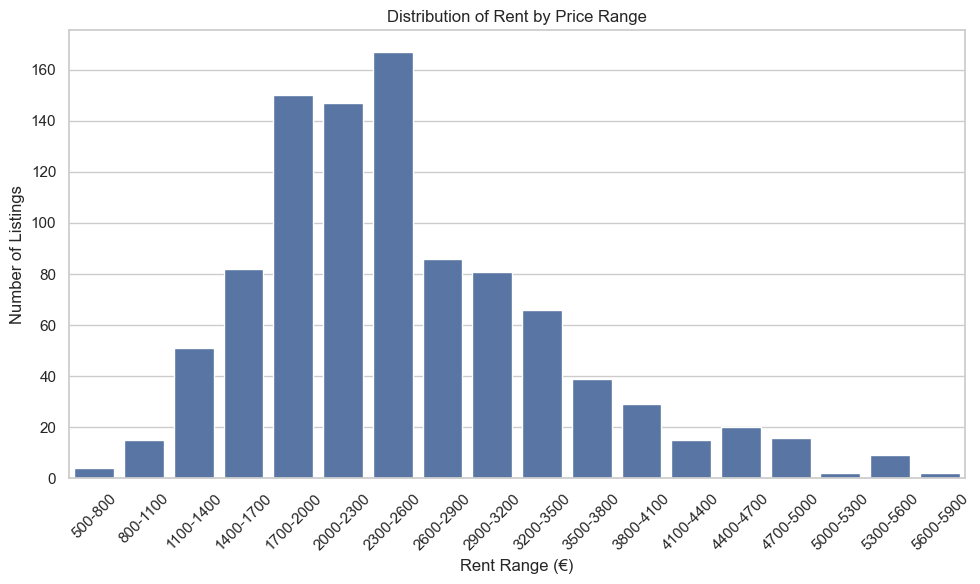

In [29]:
# Plot 1 : Rent vs Number of Listings
sns.countplot(data=df, x='price_bin', order=labels)
plt.title("Distribution of Rent by Price Range")
plt.xlabel("Rent Range (€)")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



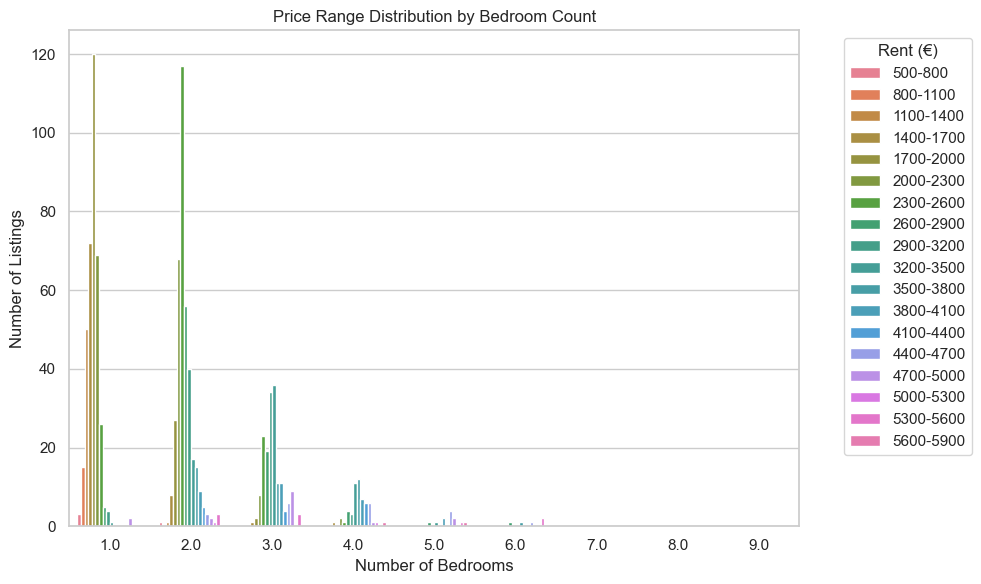

In [30]:
# Plot 2 : Rent vs Number of Bedrooms
sns.countplot(data=df, x='bedrooms', hue='price_bin', hue_order=labels)
plt.title("Price Range Distribution by Bedroom Count")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Listings")
plt.legend(title='Rent (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



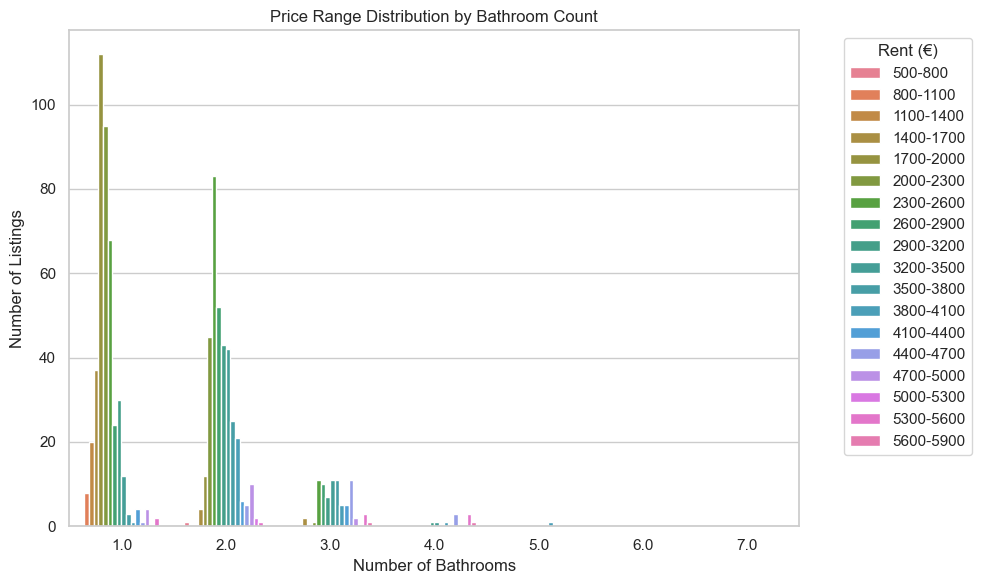

In [31]:
# Plot 3 : Rent vs Number of Bathrooms
sns.countplot(data=df, x='bathrooms', hue='price_bin', hue_order=labels)
plt.title("Price Range Distribution by Bathroom Count")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Number of Listings")
plt.legend(title='Rent (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



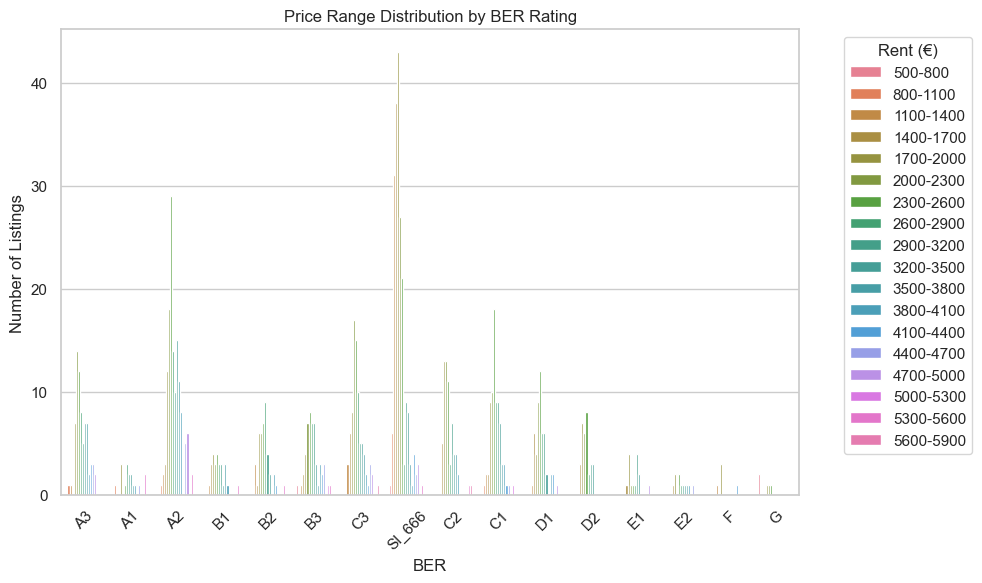

In [32]:
# Plot 4 : Rent vs BER Rating
sns.countplot(data=df, x='ber', hue='price_bin', hue_order=labels)
plt.title("Price Range Distribution by BER Rating")
plt.xlabel("BER")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.legend(title='Rent (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


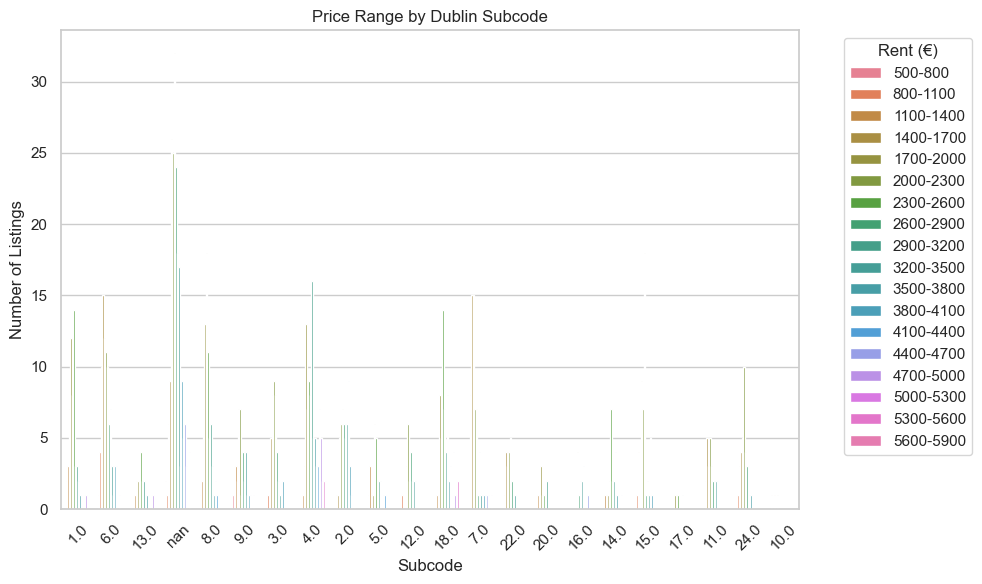

In [33]:
# Plot 5 : Rent vs Dublin Subcodes

df['dublin_subcode'] = df['dublin_subcode'].astype(str)

sns.countplot(data=df, x='dublin_subcode', hue='price_bin', hue_order=labels)
plt.title("Price Range by Dublin Subcode")
plt.xlabel("Subcode")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.legend(title='Rent (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [34]:

# Define North and South subcodes
northside = {'1', '3', '5', '7', '9', '11', '13', '15', '17'}
southside = {'2', '4', '6', '6W', '8', '10', '12', '14', '16', '18', '20', '22', '24'}

df['dublin_subcode'] = df['dublin_subcode'].astype(str)


df['dublin_subcode'] = df['dublin_subcode'].str.replace('.0', '', regex=False).str.strip().str.upper()
# Function to assign district
def map_district(code):
    if code in northside:
        return "North"
    elif code in southside:
        return "South"
    else:
        return "Unknown"

df['district'] = df['dublin_subcode'].apply(map_district)


In [35]:
df['district'].value_counts()


district
South      505
North      312
Unknown    198
Name: count, dtype: int64

Text(0.5, 1.0, 'Price Range by District')

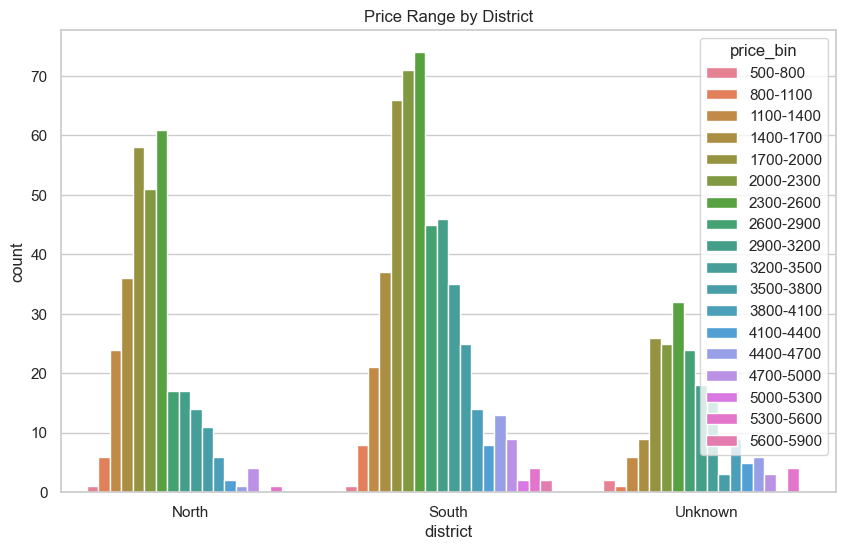

In [36]:
# Plot 6 : Rent vs District Distribution
sns.countplot(data=df, x='district', hue='price_bin', order=['North', 'South','Unknown'])
plt.title("Price Range by District")


### Observation Summary (Price-Based Trends)

- **Bedrooms and Bathrooms** show clear separation in price bands: more rooms → higher rent.
- **BER ratings** show mild inverse trends — better-rated homes (A1–B2) often command higher rent, but the pattern is noisy.
- **Subcodes and Districts** exhibit distinct pricing clusters:
  - Central and Southside areas (e.g., D2, D4, D6) are mostly in high price bins.
  - Northside districts (e.g., D1, D11) dominate the lower-to-mid price ranges.

This reinforces location and size as the strongest influencers of rent.


## Correlation Analysis (Numerical Features)

To understand linear relationships between numerical variables, we compute and visualize a Pearson correlation matrix.

This analysis helps identify:
- Which features are most associated with rent (`monthly_price`)
- Potential multicollinearity between predictors (e.g., `bedrooms` and `bathrooms`)
- Weak or redundant features that might be dropped before modeling


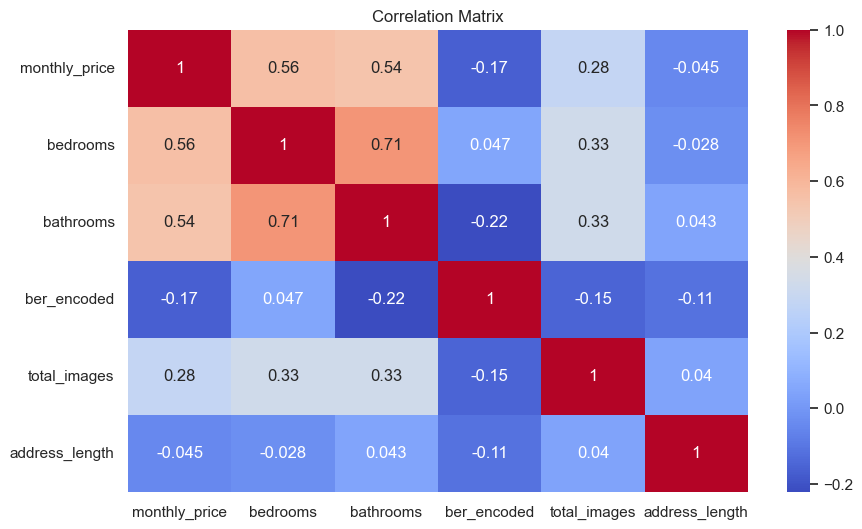

In [37]:
# Converting BER rating to ordinal numbers
ber_order = {
    'A1': 1, 'A2': 2, 'A3': 3,
    'B1': 4, 'B2': 5, 'B3': 6,
    'C1': 7, 'C2': 8, 'C3': 9,
    'D1': 10, 'D2': 11,
    'E1': 12, 'E2': 13,
    'F': 14, 'G': 15
}
df['ber_encoded'] = df['ber'].map(ber_order)
df['address_length'] = df['address'].apply(lambda x: len(str(x)))
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric features
num_cols = ['monthly_price', 'bedrooms', 'bathrooms', 'ber_encoded', 'total_images', 'address_length']

# Drop rows with NA in any of the selected columns
corr_df = df[num_cols].dropna()

# Plot correlation matrix
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


### Correlation Insights

- **Bedrooms and Bathrooms** are highly correlated (0.71) — larger properties tend to have both.
- **Monthly Rent** shows strong positive correlation with:
  - `bedrooms` (0.56)
  - `bathrooms` (0.54)
  - `total_images` (0.28) — possibly better-presented listings
- **BER Rating (`ber_encoded`)** has a mild negative correlation with rent (–0.17) — more efficient homes tend to have slightly higher rents.
- **Address Length** shows negligible correlation (–0.04), confirming it's not useful for modeling in this dataset.

We will retain the relevant features and remove low-value ones like `address_length` in the next stage.


In [38]:

df = df.drop(columns=['address_length'], errors='ignore')
output_path = "../01_data/cleaned/daft_listings_post_eda.xlsx"
df.to_excel(output_path, index=False)
print(f"EDA dataset saved to: {output_path}")


EDA dataset saved to: ../01_data/cleaned/daft_listings_post_eda.xlsx
